In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose # = Deconvolution2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [2]:
# TODO:
# image normalization
# find how to use multithreading in jupyter on windows

In [110]:
def showHsv(img):    
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(img)
    plt.show()

In [101]:
img_in = cv2.imread('pic.jpg')
# maybe should switch to LAB colorspace?
hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
print(hsv.shape)

h,s,v = cv2.split(hsv)
#print('s',s.shape)
s = (np.random.random(s.shape) * 255).astype('uint8')
h = (np.random.random(s.shape) * 255).astype('uint8')
#s = np.maximum(0, v)
#print(s)
hsv = cv2.merge([h,s,v])
print('image with its value untouched, but saturation and hue randomized:')
#showHsv(hsv)

(1008, 1600, 3)
image with its value untouched, but saturation and hue randomized:


In [6]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


In [7]:
n = 10000
X = np.arange(n).reshape(n,1)
X = np.hstack((np.ones(n).reshape(n,1), X))
print(X.shape)
y = np.random.randn(n)*50 + X[:, 1]
#y = y.reshape(n,1)
print(y.shape, X[:,1].shape)
#print(y)
#plt.plot(X[:,1], y)
yval = y
X = np.hstack((X, yval[:,None]))
# labels: 1 if above line, 0  below
y = y > X[:,1]
y = y.reshape(n,1)
y = np.hstack((y, ~y )).astype('uint8')
print(y.shape)
colors = ['red' if i  else 'green' for i in y[:,0]]
#plt.scatter(X[:,1], yval, color=colors)
#plt.show()
#print(y)
#print(X)


(10000, 2)
(10000,) (10000,)
(10000, 2)


In [8]:
def createTestModel(layers):
    model = Sequential()
    #print(X.shape[1])
    model.add(Dense(layers[0], input_dim=X.shape[1], kernel_regularizer=l2(0.001)) ) 
    model.add(Activation('relu'))
    for l in layers[1:]:
        model.add(Dense(l, kernel_regularizer=l2(0.001)))
        model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                 metrics=['accuracy'])
    return model

In [65]:
def loadImgHsv(path):
    img_in = cv2.imread(path)
    hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    X = v
    Y = np.dstack((h,s))
    #print("loadX.shape", X.shape, 'loadY.shape', Y.shape)
    return X, Y

# celebA dataset from https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg
# 202,599 images of size 178x218

# data generator for feeding into memory parts of dataset
class DataGenerator(tf.keras.utils.Sequence):
    'data generator for feeding into memory parts of dataset'
    def __init__(self, list_IDs, batch_size=32, dim=(178,218), in_channels=1,
                 out_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(list_IDs_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        # target 2 channels
        Y = np.empty((self.batch_size, *self.dim, self.out_channels))
        # print(X.shape, Y.shape)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i], Y[i] = loadImgHsv('data/img_celeba/' + ID)
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        X = np.expand_dims(X, axis=len(X.shape))
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        return X, Y

In [66]:
params = {'dim': (218, 178),
          'batch_size': 32,
          'in_channels': 1,
          'out_channels': 2,
          'shuffle': True}

data_IDs = os.listdir('data/img_celeba/')
print('dataset size',len(data_IDs))
splitAt = int(len(data_IDs)*0.01)
print('splitat', splitAt)
train_IDs = data_IDs[:splitAt]
print('train len', len(train_IDs))
val_IDs = data_IDs[splitAt:int(splitAt + splitAt/10)]
print('val len', len(val_IDs))

training_generator = DataGenerator(train_IDs, **params)
validation_generator = DataGenerator(val_IDs, **params)
print(training_generator[0][1].shape )

dataset size 202599
splitat 2025
train len 2025
val len 202
(32, 218, 178, 2)


In [67]:
# tmp = []
# print(len(training_generator))
# for i in range(len(training_generator)):
#     tmp.append(training_generator[i])
# print(len(tmp))
# tmp[0]

In [68]:
def createModel(input_shape = (218,178)):
    input_shape = input_shape + (1,)
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(3, 3), 
           activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    print('m',model.output_shape)
    kernel_size = np.array(input_shape - np.array(model.output_shape[1:]) + 1)
    kernel_size = (kernel_size/4).astype(int)
    kernel_size = tuple(kernel_size[:-1])
    print('k',kernel_size)
    model.add(Conv2DTranspose(filters=2, kernel_size=kernel_size))
    kernel_size = (51,48)
    model.add(Conv2DTranspose(filters=2, kernel_size=kernel_size))
    kernel_size = (54,48)
    model.add(Conv2DTranspose(filters=2, kernel_size=kernel_size))
    kernel_size = (58,38)
    model.add(Conv2DTranspose(filters=2, kernel_size=kernel_size))
    
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mae','accuracy'])
    return model
model = createModel()
model.summary()
print(model.output_shape)

m (None, 6, 5, 32)
k (53, 43)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 73, 60, 16)        160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 30, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 10, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 5, 32)          0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 58, 47, 2)         145858    
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 108, 94, 2)        9794      
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 161, 141, 

In [69]:
x = model.layers[0]
x.input

<tf.Tensor 'conv2d_8_input:0' shape=(?, 218, 178, 1) dtype=float32>

In [70]:
currTime = time.strftime("%d-%m-%Y-%H-%M-%S", time.localtime())
layers = ['convmax_convmax_4xDeConv']
NAME = f"test-tensorboard-{ currTime }-layers-" + "_".join(str(l) for l in layers)
print(NAME)

model = createModel()
tensorboard = TensorBoard(log_dir=f'logs/{NAME}')
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=3,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
#mode.fit(X, y, batch_size=32, epochs=10, validation_split=0.2, callbacks=[tensorboard])

test-tensorboard-17-03-2019-20-02-59-layers-convmax_convmax_4xDeConv
m (None, 6, 5, 32)
k (53, 43)
Epoch 1/3
63/63 [==============================] - 28s 450ms/step - loss: 7018.7490 - mean_absolute_error: 57.9654 - acc: 0.6603 - val_loss: 5301.8385 - val_mean_absolute_error: 51.1833 - val_acc: 0.6940
Epoch 2/3
63/63 [==============================] - 22s 350ms/step - loss: 4812.0647 - mean_absolute_error: 49.8008 - acc: 0.6922 - val_loss: 4948.2604 - val_mean_absolute_error: 49.6239 - val_acc: 0.6941
Epoch 3/3
63/63 [==============================] - 22s 347ms/step - loss: 4440.3354 - mean_absolute_error: 48.6524 - acc: 0.6932 - val_loss: 4460.5989 - val_mean_absolute_error: 47.8271 - val_acc: 0.6946


In [208]:
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=3,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])

Epoch 1/3
63/63 [==============================] - 22s 355ms/step - loss: 3339.5147 - mean_absolute_error: 44.9056 - acc: 0.6913 - val_loss: 3631.0250 - val_mean_absolute_error: 47.6408 - val_acc: 0.6949
Epoch 2/3
63/63 [==============================] - 22s 351ms/step - loss: 3330.1413 - mean_absolute_error: 44.8417 - acc: 0.6913 - val_loss: 3651.1425 - val_mean_absolute_error: 48.3054 - val_acc: 0.6949
Epoch 3/3
63/63 [==============================] - 22s 353ms/step - loss: 3333.9004 - mean_absolute_error: 44.8788 - acc: 0.6914 - val_loss: 3610.3140 - val_mean_absolute_error: 47.2434 - val_acc: 0.6949


In [238]:
def showImgFromPredict(hs, v):
    '''hs- a list containing hue and saturation matrices
    v - value matrix.
    all three should be uint8
    '''
    hs, v = hs[0], v[0,...,0]
#     print('hs:',hs.shape)
    h, s = hs[...,0], hs[...,1]
    print('h',h.shape,'s',s.shape,'v',v.shape)
    print(h.dtype, s.dtype, v.dtype)
    hsv = cv2.merge([h,s,v])
    showHsv(hsv)    

    for i in range(2,-1,-1):
        pic = hsv[:,:,i]
        plt.imshow(pic, cmap='gray')
        plt.show()


(32, 218, 178, 1) (32, 218, 178, 2)
(218, 178) (218, 178, 2)
(1, 218, 178, 1) (1, 218, 178, 2)
(1, 218, 178, 1) (1, 218, 178, 2)
uint8 0 255 109.983635707659
-7.568101 187.5567 84.6845
0 187 84.18447840428821
h (218, 178) s (218, 178) v (218, 178)
uint8 uint8 uint8


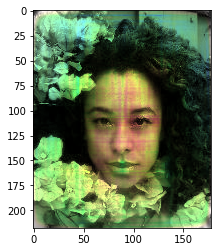

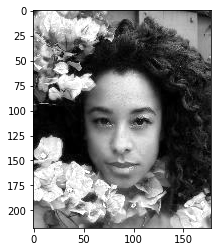

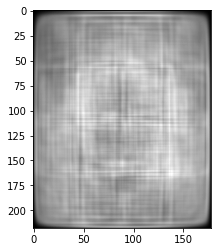

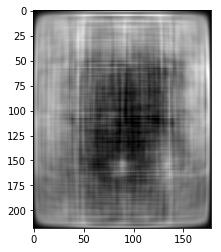

In [240]:
#model.get_config()
X, Y = validation_generator[1]
print(X.shape, Y.shape)

inX, inY = loadImgHsv('data/img_celeba/000044.jpg' )
print(inX.shape,inY.shape)
inX, inY = inX[None,...,None], inY[None,:]
print(inX.shape,inY.shape)
X, Y = X[10][None,:], Y[0][None,:]
print(X.shape, Y.shape)

X, Y = inX, inY

predY = model.predict(X)

print(X.dtype, X.min(), X.max(), X.mean())
#predY = int(predY)
print(predY.min(), predY.max(), predY.mean() )
predY = predY
predY = np.maximum(predY, 0)
X = X.astype('uint8')
predY = predY.astype('uint8')
print(predY.min(), predY.max(), predY.mean() )

showImgFromPredict(predY, X)

In [242]:
# pred = model.predict_classes(X).reshape((-1,))
# pred = 1 - pred
# #print(pred)
# evaluation = model.evaluate(X, y)
# print(f'loss:{evaluation[0]}\naccuracy:{evaluation[1]}')
# labels = y[:,0]
# #print(labels.shape, labels)
# incorrects = np.nonzero(np.not_equal(pred, labels) )
# print('num incorrect', len(incorrects[0]))
# #print('incorr:',incorrects)
# print('\nwrong pred:', pred[incorrects])
